## Runnning with gammapy-dev/IRF_model


loaded gammapy version: 0.1.dev20025+g3b82a43.d20230724 
Supposed to be 1.0 (21-12-2022)
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
20

0
shift [-0.17382677], tilt [-0.02171259]
3.1752057518634e-12   1.4506992108306441e-12   1.9732275808809334   0.6552042435479819   0.2514428282660839   0.2981531172593315   0.98059962655868   0.015492676214759199   0.0390655030224458   0.017468944399413783   
3.1828780605190753e-12   1.5708351304242458e-12   1.9697887612510883   0.658135607637023   0.2535629279467205   0.2998509802746132   0.9806378291035792   0.015493713109561949   0.03909182700934872   0.017469274131922573   0.0   0.0   0.0   0.0   

0.10000000000000002 TeV 0.1778279410038923 TeV

0.1778279410038923 TeV 0.316227766016838 TeV

0.316227766016838 TeV 0.5623413251903491 TeV

0.5623413251903491 TeV 1.0 TeV

1.0 TeV 1.7782794100389232 TeV

1.7782794100389232 TeV 3.1622776601683795 TeV

3.1622776601683795 TeV 5.623413251903

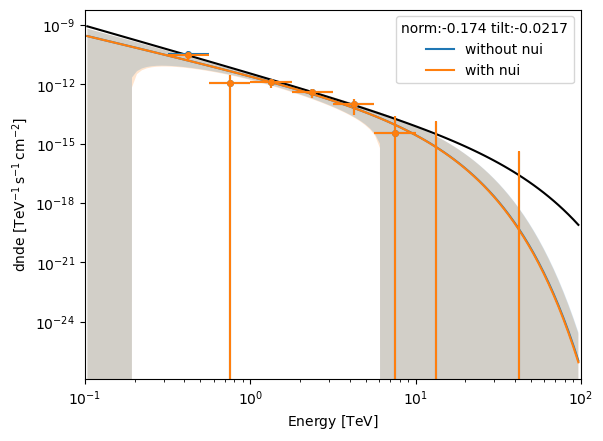

In [6]:

def save():
    with open("data/7aP_P_draw_info.txt", "a") as myfile:
        myfile.write(str(float(bias_rnd[0])) + '    '+ str(float(res_rnd[0])) + '    ' +  str(float(dataset.stat_sum())) + '\n')
    with open("data/7aP_P_draw_par.txt", "a") as myfile:
        myfile.write(stri + '\n')
    with open("data/7aP_P_draw_flux.txt", "a") as myfile:
        myfile.write( ff + '\n')
    with open("data/7aP_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ff2 + '\n')

    with open("data/7aP_N_P_draw_par.txt", "a") as myfile:
        myfile.write(stri_N + '\n')
    with open("data/7aP_N_P_draw_flux.txt", "a") as myfile:
        myfile.write( ffN + '\n')
    with open("data/7aP_N_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ffN2 + '\n')


import gammapy 
import pyximport
import numpy as np
import astropy.units as u
import sys
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
from gammapy.modeling.models import IRFModels, EffAreaIRFModel, ERecoIRFModel
    
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
import Dataset_load 
from  Dataset_Setup import Setup, GaussianCovariance_matrix

pyximport.install()

print(f'loaded gammapy version: {gammapy.__version__} ' )
print('Supposed to be 1.0 (21-12-2022)' )


scaled_down = Parameter("amplitude", value = 3.76e-12, unit = u.Unit("1 / (TeV s cm2)"))
dataset_asimov = Dataset_load.create_asimov(
    model="crab", source="PKSflare", parameters=Parameters([scaled_down]),
    livetime = "1.0-hr"
)

mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0

ebins = dataset_asimov.counts.geom.axes[0].center[mask]
print(len(ebins))


norm = 0.1
tilt = 0.025
bias = 0.0
resolution = 0.0

N = 1

save_flux = True
save_fluxpoints = 1
save_fluxpoints_N = 1
dataset_N = True


for n in range(N):
    print()
    print('====' * 30)
    print(n)
    print('====' * 30)
    res_rnd = [0.] 
    bias_rnd =  [0.] 
    shift_rnd = np.random.normal(0, norm, 1)
    tilt_rnd = np.random.normal(0, tilt, 1)
    
    print(f"shift {shift_rnd}, tilt {tilt_rnd}")
    setup = Setup(dataset_input=dataset_asimov, rnd = True)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset, dataset_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_N)
    dataset_N.models.parameters['resolution'].frozen = True
    dataset_N.models.parameters['bias'].frozen = True

    dataset_N.irf_model.parameters['tilt'].frozen = False
    dataset_N.irf_model.parameters['norm'].frozen = False
    setup.set_irf_prior(dataset_N, bias_rnd[0], res_rnd[0], shift_rnd, tilt_rnd)
    
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([dataset])


    stri = ""
    for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
        stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
    print(stri)


    fluxes = []
    for e in ebins:
        flux =  dataset.models[0].spectral_model(e)
        fluxes.append(flux.value)

    ff = str()
    for f in fluxes:
        ff += str(f) + "  "
    #print(ff)

    energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

    energy_min, energy_max = energy_bounds
    energy = MapAxis.from_energy_bounds(
        energy_min,
        energy_max,
        len(ebins),
    )

    fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
    fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
    fluxe2 = fluxe2.quantity[:, 0, 0]
    fluxe2 = np.array(fluxe2)   
    ff2 = str()
    for f in fluxe2:
        ff2 += str(f) + "  "

    energy_edges = dataset.geoms['geom'].axes[0].edges[::2]
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([dataset_N])

    stri_N = ""
    for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt', 'bias', 'resolution']:
        stri_N += str(dataset_N.models.parameters[p].value)  + '   ' +  str(dataset_N.models.parameters[p].error)  + '   '
    print(stri_N)


    fluxes = []
    for e in ebins:
        flux =  dataset_N.models[0].spectral_model(e)
        fluxes.append(flux.value)

    ffN = str()
    for f in fluxes:
        ffN += str(f) + "  "

    energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

    energy_min, energy_max = energy_bounds
    energy = MapAxis.from_energy_bounds(
        energy_min,
        energy_max,
        len(ebins),
    )

    fluxe2, _ = dataset_N.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
    fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
    fluxe2 = fluxe2.quantity[:, 0, 0]
    fluxe2 = np.array(fluxe2)   
    ffN2 = str()
    for f in fluxe2:
        ffN2 += str(f) + "  "


    if save_fluxpoints:

        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints_N = esti.run([dataset_N])
        fluxpoints_N.write(f'data/fluxpoints/6P_fluxpoints_N_{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}.fits')
        Models([dataset_N.models[0]]).write(f'data/fluxpoints/6P_model_N_{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}.yaml')
        fluxpoints.write(f'data/fluxpoints/6P_fluxpoints_{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}.fits')
        Models([dataset.models[0]]).write(f'data/fluxpoints/6P_model_{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}.yaml')

    save()
    
    import matplotlib.pyplot as plt


    ax = dataset.models[0].spectral_model.plot((0.1,100)*u.TeV, color = 'tab:blue',
                                              label = "without nui")


    dataset_asimov.models[0].spectral_model.plot((0.1,100)*u.TeV,ax = ax, color = 'black')

    dataset_N.models[0].spectral_model.plot((0.1,100)*u.TeV,ax = ax, color = 'tab:orange',
                                           label = "with nui")
    dataset_N.models[0].spectral_model.plot_error((0.1,100)*u.TeV,ax = ax, facecolor = 'tab:orange')
    dataset.models[0].spectral_model.plot_error((0.1,100)*u.TeV,ax = ax, facecolor = 'tab:blue')

    fluxpoints_N.plot(ax =ax)
    fluxpoints.plot(ax =ax)
    ax.legend(title = f"norm:{shift_rnd[0]:.3} tilt:{tilt_rnd[0]:.3}")
    fig = plt.gcf()
    fig.savefig(f"data/plot_{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}.png")
    
    
    
    
